In [ ]:
from utils.dataset import *

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon, shape
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
from dotenv import load_dotenv


In [13]:
load_dotenv(override=True)

True

In [14]:
BASE_DIR = os.environ.get("BASE_DIR", "CAM-ForestNetDataset")
SUB_DIR = os.environ.get("SUB_DIR", "Landsat-Detailed-Timeseries")

BASE_PATH = f"{BASE_DIR}/{SUB_DIR}"
FILE_CLEANING_PATH = os.environ.get("EXAMPLES_FOLDER", "examples")
DATASET_LIST = os.environ.get("DATASET_OPTIONS", "Landsat-Detailed-Timeseries, Landsat-Detailed, Landsat-Grouped").split(", ")
TIMESERIES_LENGTH = int(os.environ.get("TIMESERIES_LENGTH", 5))

In [ ]:
import pandas as pd

NEW_CSV_FILE = False

if NEW_CSV_FILE:
    df = pd.read_csv(f'{BASE_PATH}/all.csv')
    new_rows = []
    for _, row in df.iterrows():
        for i in range(5):  # _0 to _4
            new_row = row.copy()
            new_row['example_path'] = f"{row['example_path']}_{i}"
            new_rows.append(new_row)

    # Create new DataFrame while maintaining order
    expanded_df = pd.DataFrame(new_rows)

    expanded_df.to_csv(f'{BASE_PATH}/expanded_all.csv', index=False)

                 label         merged_label  latitude  longitude  year  \
0  Oil palm plantation  Oil palm plantation  3.918750   9.896375  2015   
0  Oil palm plantation  Oil palm plantation  3.918750   9.896375  2015   
0  Oil palm plantation  Oil palm plantation  3.918750   9.896375  2015   
0  Oil palm plantation  Oil palm plantation  3.918750   9.896375  2015   
0  Oil palm plantation  Oil palm plantation  3.918750   9.896375  2015   
1    Rubber plantation    Rubber plantation  3.472625  10.082750  2015   
1    Rubber plantation    Rubber plantation  3.472625  10.082750  2015   
1    Rubber plantation    Rubber plantation  3.472625  10.082750  2015   
1    Rubber plantation    Rubber plantation  3.472625  10.082750  2015   
1    Rubber plantation    Rubber plantation  3.472625  10.082750  2015   

                                      example_path  
0  examples/9.896374999999999_3.9187499999999997_0  
0  examples/9.896374999999999_3.9187499999999997_1  
0  examples/9.896374999999

In [17]:

def count_folders(base_path, file_cleaning_path):
    """Count all subfolders in the target path"""
    path = Path(base_path) / file_cleaning_path
    if not path.exists():
        return 0
    return len([d for d in path.iterdir() if d.is_dir()])

def resolve_pkl_path(base_path, example_path):
    coord_folder = '_'.join(example_path.split('_')[:-1])  # Removes trailing _0, _1 etc.
    
    for dataset_type in DATASET_LIST:
        possible_path = os.path.join(
            base_path,
            dataset_type,
            FILE_CLEANING_PATH,
            coord_folder,
            'forest_loss_region.pkl'
        )
        if os.path.exists(possible_path):
            return possible_path
    
    return None

def clean_dataset(csv_file, file_cleaning_path, base_path, output_csv="all.csv"):
    initial_count = count_folders(base_path, file_cleaning_path)
    print(f"Initial folder count: {initial_count}")
    
    df = pd.read_csv(csv_file)
    
    referenced_folders = set()
    valid_rows = []
    
    for _, row in df.iterrows():
        folder_path = os.path.join(base_path, row['example_path'])
        if os.path.exists(folder_path):
            referenced_folders.add(folder_path)
            valid_rows.append(row)
    
    cleaned_df = pd.DataFrame(valid_rows)
    cleaned_df.to_csv(os.path.join(base_path, output_csv), index=False)
    
    data_root = os.path.join(base_path, file_cleaning_path)
    if os.path.exists(data_root):
        all_folders = {os.path.join(data_root, d) for d in os.listdir(data_root) 
                      if os.path.isdir(os.path.join(data_root, d))}
        
        folders_to_remove = all_folders - referenced_folders
        
        referenced_count = len(referenced_folders)
        print(f"Referenced folders: {referenced_count}")
        print(f"Unreferenced folders to remove: {len(folders_to_remove)}")

        for folder in folders_to_remove:
            try:
                shutil.rmtree(folder)
                print(f"Removed unreferenced folder: {folder}")
            except Exception as e:
                print(f"Error removing {folder}: {e}")
        
        final_count = count_folders(base_path, file_cleaning_path)
        print(f"\nValidation:")
        print(f"Initial folders: {initial_count}")
        print(f"Referenced folders: {referenced_count}")
        print(f"Final folders remaining: {final_count}")
        print(f"Folders removed: {initial_count - final_count}")
        
        # Verify no folders were incorrectly removed
        if final_count != referenced_count:
            print("Warning: Folder counts don't match!")
            print("Possible causes:")
            print("- Some referenced folders were missing")
            print("- Permission issues during deletion")
        else:
            print("Validation successful - counts match")
    
    return cleaned_df


cleaned_df = clean_dataset(os.path.join(BASE_PATH, 'all.csv'), FILE_CLEANING_PATH, BASE_PATH)

Initial folder count: 3634
Referenced folders: 3634
Unreferenced folders to remove: 0

Validation:
Initial folders: 3634
Referenced folders: 3634
Final folders remaining: 3634
Folders removed: 0
Validation successful - counts match


In [18]:
if "Timeseries" in BASE_PATH:
    cleaned_df, stats = filter_timeseries_by_length(cleaned_df, TIMESERIES_LENGTH)

    print(f"Total locations: {stats['total_locations']}")
    print(f"Locations with ≥{stats['min_length']} images: {stats['filtered_locations']} ({stats['filtered_percentage']:.1%})")

Total locations: 784
Locations with ≥5 images: 670 (85.5%)


In [10]:

def get_class_dist(df):
    return df['merged_label'].value_counts(normalize=True).to_dict()

def load_shapefile_edges(
    data, path_column="example_path", label_column="merged_label"
):
    data.columns = data.columns.str.lower().str.strip()

    original_columns = data.columns.tolist()

    extracted_edges = []
    file_not_found_count = 0

    for _, row in data.iterrows():
        path = os.path.join(BASE_PATH, row[path_column])
        pkl_path = os.path.join(path, "forest_loss_region.pkl")

        if os.path.exists(pkl_path):
            try:
                with open(pkl_path, "rb") as f:
                    shapefile_data = pickle.load(f)

                if isinstance(shapefile_data, (Polygon, MultiPolygon)):
                    geometries = [shapefile_data]
                elif isinstance(shapefile_data, list):
                    geometries = shapefile_data
                elif isinstance(shapefile_data, dict) and "features" in shapefile_data:
                    geometries = [
                        shape(feature["geometry"])
                        for feature in shapefile_data["features"]
                    ]
                else:
                    print(f"Unknown format in {pkl_path}, skipping...")
                    continue

                for geom in geometries:
                    if geom.boundary:
                        row_dict = row.to_dict()
                        row_dict["edge"] = geom.boundary
                        extracted_edges.append(row_dict)

            except Exception as e:
                print(f"Error loading {pkl_path}: {e}")
        else:
            print(f"Warning: File not found {pkl_path}")
            file_not_found_count += 1

    print(
        f"{file_not_found_count} files missing out of {len(data)}."
    )
    df = pd.DataFrame(extracted_edges)

    for col in original_columns:
        if col not in df.columns:
            df[col] = np.nan

    return df[original_columns + ["edge"]]

def save_dataframes(train_data, test_data, val_data, base_path):
    original_data = pd.read_csv(os.path.join(base_path, 'all.csv'))
    original_columns = original_data.columns.tolist()

    for col in original_columns:
        for df in [train_data, test_data, val_data]:
            if col not in df.columns:
                df[col] = np.nan

    train_data[original_columns].to_csv(os.path.join(base_path, "train.csv"), index=False)
    test_data[original_columns].to_csv(os.path.join(base_path, "test.csv"), index=False)
    val_data[original_columns].to_csv(os.path.join(base_path, "val.csv"), index=False)

    print("Train, Test, and Validation sets saved.")


def geographically_dispersed_split(data, target_ratios=(0.6, 0.25, 0.15), min_separation_km=0.5):
    data['coord'] = data['example_path'].str.extract(r'([\d\.]+_[\d\.]+)')
    
    coord_groups = []
    for coord, group in data.groupby('coord'):
        if len(group) == 0:
            continue
            
        try:
            geom = group['edge'].iloc[0]
            if geom and hasattr(geom, 'centroid'):
                coord_groups.append((coord, group))
        except Exception as e:
            print(f"Skipping {coord}: {str(e)}")
            continue
            
    if not coord_groups:
        raise ValueError("No valid coordinate groups found with geometries")
    
    coord_groups = np.array(coord_groups, dtype=object)
    
    centroids = []
    valid_indices = []
    for i, (coord, group) in enumerate(coord_groups):
        try:
            geom = group['edge'].iloc[0]
            if geom and hasattr(geom, 'centroid'):
                centroids.append(geom.centroid)
                valid_indices.append(i)
        except:
            continue
    
    if not centroids:
        raise ValueError("No valid centroids could be calculated")
    
    coord_groups = coord_groups[valid_indices]
    coords = np.array([[pt.y, pt.x] for pt in centroids])
    
    if coords.size == 0:
        raise ValueError("No valid coordinates found")
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError(f"Invalid coordinates shape: {coords.shape}. Expected (n, 2)")
    
    kdtree = cKDTree(coords)
    
    n_groups = len(coord_groups)
    assigned = np.full(n_groups, False)
    test_size = int(n_groups * target_ratios[1])
    val_size = int(n_groups * target_ratios[2])

    test_indices = []
    if test_size > 0:
        center = np.mean(coords, axis=0)
        distances = np.array([geodesic(center, (y,x)).km for y,x in coords])
        test_indices.append(np.argmax(distances))
        assigned[test_indices[-1]] = True
        
        with tqdm(total=test_size-1, desc="Selecting test sites") as pbar:
            while len(test_indices) < test_size:
                dists, _ = kdtree.query(coords[test_indices], k=n_groups)
                valid_mask = np.all(dists > min_separation_km, axis=0)
                valid_mask[assigned] = False
                
                if not np.any(valid_mask):
                    min_separation_km *= 0.8
                    continue
                
                min_dists = np.min(dists[:, valid_mask], axis=0)
                next_idx = np.where(valid_mask)[0][np.argmax(min_dists)]
                test_indices.append(next_idx)
                assigned[next_idx] = True
                pbar.update(1)
    
    val_indices = []
    if val_size > 0:
        with tqdm(total=val_size, desc="Selecting validation sites") as pbar:
            while len(val_indices) < val_size:
                ref_indices = test_indices + val_indices
                if ref_indices:
                    dists, _ = kdtree.query(coords[ref_indices], k=n_groups)
                    valid_mask = np.all(dists > min_separation_km, axis=0)
                else:
                    valid_mask = np.ones(n_groups, dtype=bool)
                
                valid_mask[assigned] = False
                
                if not np.any(valid_mask):
                    min_separation_km *= 0.8
                    continue
                
                if ref_indices:
                    min_dists = np.min(dists[:, valid_mask], axis=0)
                    next_idx = np.where(valid_mask)[0][np.argmax(min_dists)]
                else:
                    center = np.mean(coords[~assigned], axis=0)
                    distances = np.array([geodesic(center, (y,x)).km for y,x in coords[~assigned]])
                    next_idx = np.where(~assigned)[0][np.argmax(distances)]
                
                val_indices.append(next_idx)
                assigned[next_idx] = True
                pbar.update(1)
    
    train_indices = ~assigned
    
    train = pd.concat([coord_groups[i][1] for i in np.where(train_indices)[0]]).assign(split='train')
    test = pd.concat([coord_groups[i][1] for i in test_indices]).assign(split='test')
    val = pd.concat([coord_groups[i][1] for i in val_indices]).assign(split='val')

    stats = {
        'class_distribution': {
            'train': get_class_dist(train),
            'test': get_class_dist(test),
            'val': get_class_dist(val)
        },
        'split_counts': {
            'train': len(train_indices),
            'test': len(test_indices),
            'val': len(val_indices)
        },
        "min_separation_km": min_separation_km
    }

    return train, test, val, stats

def stratified_sample_split(data, target_ratios=(0.6, 0.25, 0.15), random_state=42):
    assert sum(target_ratios) == 1.0
    assert len(target_ratios) == 3
    
    data['coord'] = data['example_path'].str.extract(r'([\d\.]+_[\d\.]+)')
    coord_groups = data.groupby('coord')
    
    group_classes = {}
    for coord, group in coord_groups:
        majority_class = group['merged_label'].mode()[0]
        group_classes[coord] = majority_class
    
    groups = list(group_classes.keys())
    classes = [group_classes[g] for g in groups]
    
    train_groups, temp_groups = train_test_split(
        groups,
        test_size=(1 - target_ratios[0]),
        stratify=classes,
        random_state=random_state
    )
    
    test_ratio = target_ratios[1] / (target_ratios[1] + target_ratios[2])
    test_groups, val_groups = train_test_split(
        temp_groups,
        test_size=test_ratio,
        stratify=[group_classes[g] for g in temp_groups],
        random_state=random_state
    )
    
    train = data[data['coord'].isin(train_groups)].assign(split='train')
    test = data[data['coord'].isin(test_groups)].assign(split='test')
    val = data[data['coord'].isin(val_groups)].assign(split='val')
    
    stats = {
        'class_distribution': {
            'train': get_class_dist(train),
            'test': get_class_dist(test),
            'val': get_class_dist(val)
        },
        'split_counts': {
            'train': len(train_groups),
            'test': len(test_groups),
            'val': len(val_groups)
        }
    }
    
    return train, test, val, stats

df_edges = load_shapefile_edges(cleaned_df)
train_data, test_data, val_data, stats = stratified_sample_split(df_edges)

save_dataframes(train_data, test_data, val_data, BASE_PATH)

total_points = len(train_data) + len(test_data) + len(val_data)
print(f"\nFinal Split:")
print(f"Train: {len(train_data)} points ({len(train_data.groupby('coord'))} sites)")
print(f"Test: {len(test_data)} points ({stats.get('test_sites', len(test_data.groupby('coord')))} sites)")
print(f"Validation: {len(val_data)} points ({stats.get('val_sites', len(val_data.groupby('coord')))} sites)")
if 'min_separation_km' in stats:
    print(f"Achieved minimum separation: {stats['min_separation_km']:.2f} km")


0 files missing out of 4305.
Train, Test, and Validation sets saved.

Final Split:
Train: 2580 points (516 sites)
Test: 645 points (129 sites)
Validation: 1080 points (216 sites)


/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


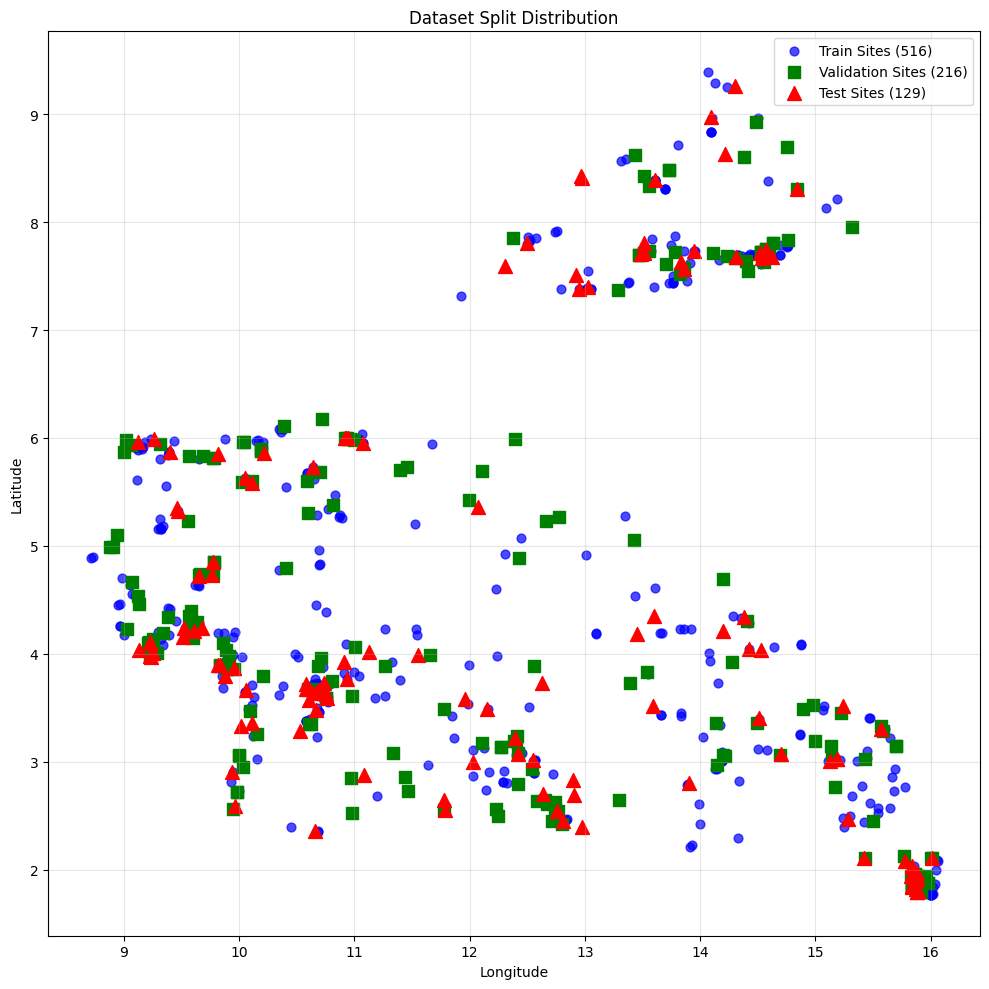

In [11]:
def plot_split_distribution(train, test, val, stats):
    plt.figure(figsize=(10, 10))
    
    split_settings = [
        {'name': 'Train', 'color': 'blue', 'marker': 'o', 'size': 40, 'alpha': 0.7},
        {'name': 'Validation', 'color': 'green', 'marker': 's', 'size': 80, 'alpha': 1.0},
        {'name': 'Test', 'color': 'red', 'marker': '^', 'size': 100, 'alpha': 1.0}
    ]
    
    for i, (split_data, settings) in enumerate(zip(
        [train, val, test],
        split_settings
    )):
        sites = split_data.groupby('coord')['edge'].apply(lambda x: x.iloc[0].centroid)
        plt.scatter(
            [c.x for c in sites],
            [c.y for c in sites],
            c=settings['color'],
            marker=settings['marker'],
            s=settings['size'],
            alpha=settings['alpha'],
            label=f"{settings['name']} Sites ({len(sites)})"
        )
    
    if 'min_separation_km' in stats:
        test_sites = test.groupby('coord')['edge'].apply(lambda x: x.iloc[0].centroid)
        val_sites = val.groupby('coord')['edge'].apply(lambda x: x.iloc[0].centroid)
        
        ax = plt.gca()
        for site in list(test_sites) + list(val_sites):
            circle = plt.Circle(
                (site.x, site.y), 
                stats['min_separation_km']/111,
                color='orange', fill=False, alpha=0.3, linestyle='--'
            )
            ax.add_patch(circle)
    
    plt.legend(loc='upper right')
    plt.title("Dataset Split Distribution" + 
             (f" (Min Separation: {stats['min_separation_km']:.2f} km)" 
              if 'min_separation_km' in stats else ""))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_split_distribution(train_data, test_data, val_data, stats)

/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat-env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/ix20088/.pyenv/versions/

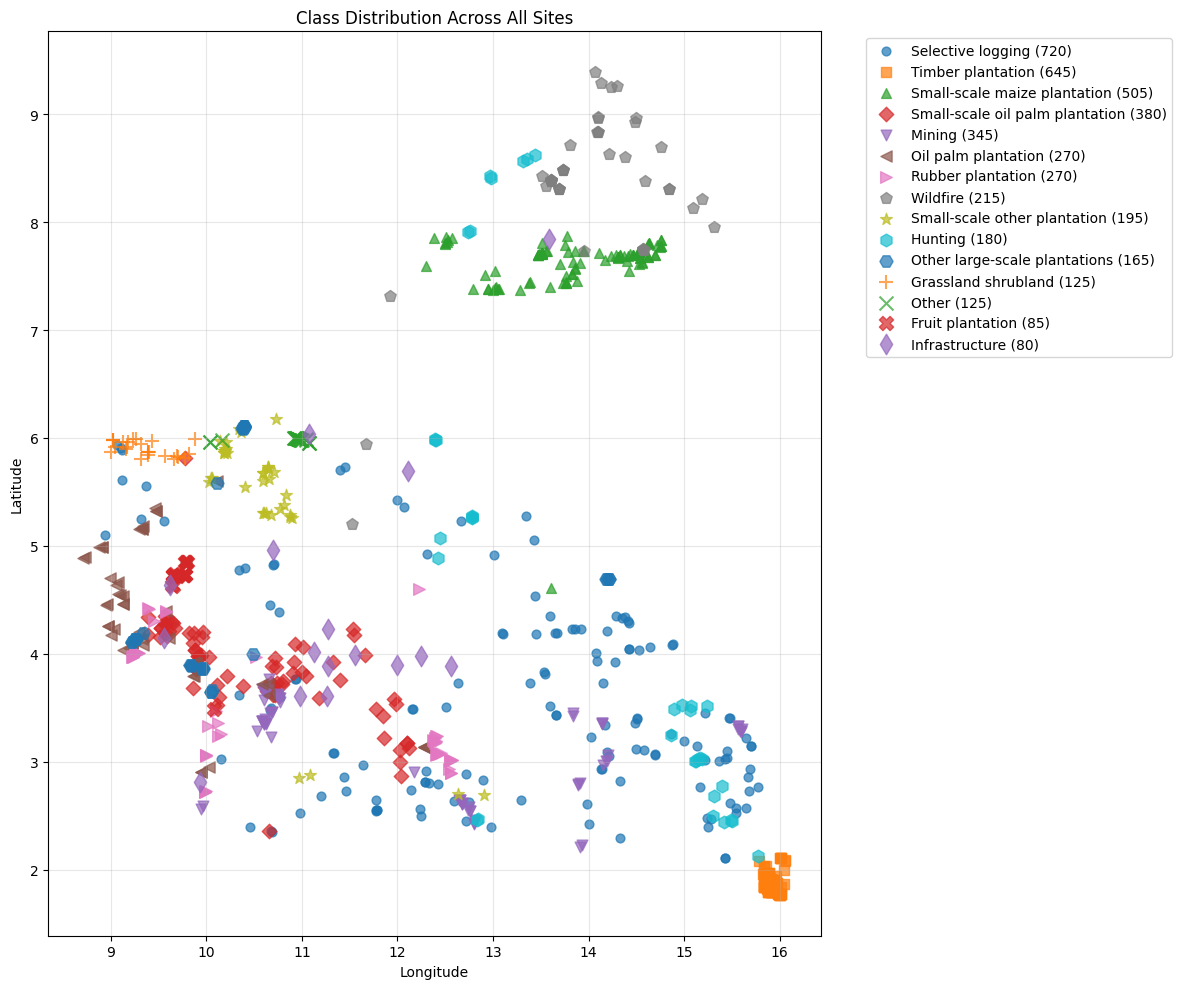

In [12]:
def plot_class_distribution(train, test, val, stats):
    plt.figure(figsize=(12, 10))
    
    all_data = pd.concat([train, test, val])
    
    class_counts = all_data['merged_label'].value_counts()
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd']
    
    for i, (class_label, count) in enumerate(class_counts.items()):
        class_sites = all_data[all_data['merged_label'] == class_label]
        centroids = class_sites.groupby('coord')['edge'].apply(lambda x: x.iloc[0].centroid)
        
        plt.scatter(
            [c.x for c in centroids],
            [c.y for c in centroids],
            marker=markers[i % len(markers)],
            s=40 + i*5,
            alpha=0.7,
            label=f'{class_label} ({count})'
        )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Class Distribution Across All Sites")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_data, test_data, val_data, stats)